In [28]:
import os
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf

In [29]:
# Test mode is set to false to avoid unwated testing outputs from the cells
test = False

The Brain tumor dataset is taken from `./brain_tumor_dataset/yes` and `brain_tumor_dataset/no` directories. 
> **Dataset Source:** https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection 
> 
> **Dataset Description**: The dataset contains 2 folders (yes/no) and each folder contains subfolders with several images. There are 253 images with brain tumor and 98 images without brain tumor. The images are in .jpg format. The image sizes are not consistent.

In [30]:
yes_imgs_name = os.listdir('./brain_tumor_dataset/yes')
no_imgs_name = os.listdir('./brain_tumor_dataset/no')

# 1. Pre-processing the images

  1. Normalization step 1 is to crop the brain out of the images.
  2. Normalization step 2 is to resize the images to a standard size of 32x32 for easier processing.
  3. Normalize pixels of the images

### 1.1 Cropping the brain out of the images
Create a function to crop the brain out an given image
<!-- MRI cropping image -->
![MRI Cropping Image](./MRIcropping.png)

  0. Resize the image to 256x256 pixels
  1. Convert the image to grayscale
  2. Apply a Gaussian blur to the image
  3. Threshold the image and perform a series of erosions and dilations to remove any small regions of noise
  4. Find the contours of the brain
  5. Find the largest contour
  6. Crop the image to the bounding box of the largest contour

In [5]:
def crop_image(img):
    # Resize the image to 256x256 pixels
    resized_img = cv2.resize(
        img,
        dsize=(256, 256),
        interpolation=cv2.INTER_CUBIC
    )
    # Convert the image to grayscale
    gray = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)

    # Apply a Gaussian blur to the image
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image by Binary Thresholding
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # perform a series of erosions & dilations to remove any small regions of noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop
    ADD_PIXELS = 0
    cropped_img = resized_img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,
                              extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return cropped_img

In [6]:
# Use crop_image function to crop the images
yes_imgs_cropped = [crop_image(cv2.imread('./brain_tumor_dataset/yes/'+img_file)) for img_file in yes_imgs_name]
no_imgs_cropped = [crop_image(cv2.imread('./brain_tumor_dataset/no/'+img_file)) for img_file in no_imgs_name]

### 1.2 Resize the cropped images

The cropped images are resized to 32x32 for easier processing.

The `resized_imgs` list contains the resized images of the `yes_imgs_cropped` and `no_imgs_cropped` lists.


In [7]:
orig_imgs: list[cv2.Mat] = yes_imgs_cropped + no_imgs_cropped
resized_imgs: list[cv2.Mat] = [cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC) for img in orig_imgs]

In [8]:
X = np.squeeze(resized_imgs)

In [9]:
if (test):
    print(type(X))
    print(X.shape)
    print(X)
    print(resized_imgs)


### 1.3 Normalize pixels of the images
Normalize each pixel of the images present in the numpy array `X` and save it as `X`.


In [10]:
# normalize data
X = X.astype('float32')
X /= 255

In [11]:
if (test):
    print(X)

# 2. Creating and Training the CNN model
  1. Create the labels for the images
  2. Prepare the training and validation/testing data
  3. Create the CNN model and visualize the model summary
  4. Compile the model
  5. Train the model on the training data
  6. Evaluate the model

### 2.1. Create the labels for the images
The `img_labels` list stores the labels for each image. The labels are 0 for "no" and 1 for "yes".


In [12]:
labels_yes = np.full(len(yes_imgs_name), 1)
labels_no = np.full(len(no_imgs_name), 0)

img_labels = np.concatenate([labels_yes, labels_no])

In [13]:
if (test):
    print(img_labels.size, img_labels)


### 2.2 Prepare the training and validation/testing data

Prepare `x_train` and `x_valid` from the `X` image data list.
Prepare `y_train` and `y_valid` from the `img_labels` list.

As stated above, the dataset is divided into 2 directories: "yes" & "no". There are 253 images (155 images for "yes" and 98 images for "no"). We were storing the labels for each image in the `img_labels` list. The labels are 0 for "no" and 1 for "yes".

So we are separately storing the images of "yes" and "no" in the `yes_imgs` and `no_imgs` lists respectively and thier labels in the `yes_labels` and `no_labels` lists respectively.

We will divide those images into training and validation sets. We will use 80% of the images for training and 20% of the images for validation. So we will use 202 images for training and 51 images for validation. Out of 202 images, 124 images are of "yes" and 78 images are of "no". Similarly, out of 51 images, 31 images are of "yes" and 20 images are of "no".


In [14]:
# Splitting the dataset into the Training set (i.e `x_train`) and Testing set/Validation set (i.e `x_valid`)
# We will also keep the original images of the validation set in `x_orig_valid` for visualization purposes
yes_imgs = X[:155]
no_imgs = X[155:]
yes_orig_imgs = orig_imgs[:155]
no_orig_imgs = orig_imgs[155:]

x_yes_train = yes_imgs[:124]
x_yes_valid = yes_imgs[124:]
x_yes_orig_valid = yes_orig_imgs[124:]

x_no_train = no_imgs[:78]
x_no_valid = no_imgs[78:]
x_no_orig_valid = no_orig_imgs[78:]

x_train = np.concatenate([x_yes_train, x_no_train])
x_valid = np.concatenate([x_yes_valid, x_no_valid])
x_orig_valid = np.concatenate([x_yes_orig_valid, x_no_orig_valid])

# Splitting the dataset labels for the Training set (i.e `y_train`) and Testing set/Validation set (i.e `y_valid`)
yes_labels = img_labels[:155]
no_labels = img_labels[155:]

y_yes_train = yes_labels[:124]
y_yes_valid = yes_labels[124:]

y_no_train = no_labels[:78]
y_no_valid = no_labels[78:]

y_train = np.concatenate([y_yes_train, y_no_train])
y_valid = np.concatenate([y_yes_valid, y_no_valid])


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### 2.3.1 Create the CNN model

Prepare the CNN Sequential model with 3 convolutional layers and 2 dense layers. Use the `relu` activation function for the convolutional layers and `sigmoid` activation function for the last dense layer.

In [15]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=9,
          padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(
    filters=16, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(
    filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model summary
# model.summary() # Uncomment to see the model summary. Model summary is already been shown the cell below in SVG representation


2022-12-06 20:57:51.780725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/linuxbrew/.linuxbrew/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-06 20:57:51.780964: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 20:57:51.780986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linu): /proc/driver/nvidia/version does not exist
2022-12-06 20:57:51.782293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2.3.2 Visualize the model summary
Visualize the SVG representation of the model.

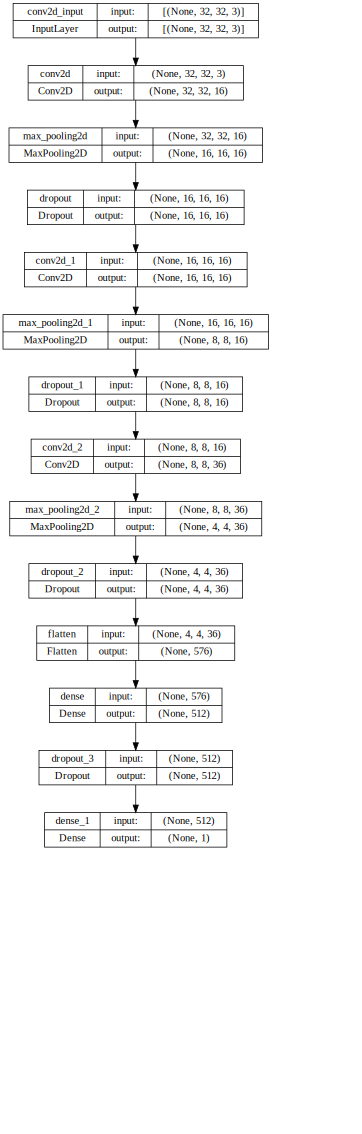

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


### 2.4 Compile the model
Use the `binary_crossentropy` loss function and `adam` optimizer to compile model.

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])


### 2.5 Train the model on the training data
Train the model for 200 epochs with a batch size of 128. Use the `validation_data` parameter to pass the validation data.

In [18]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=200,
          validation_data=(x_valid, y_valid),)

# Saving the trained model
model.save('brain_tumor_detection_model.h5')

Epoch 1/200
1/2 [==============>...............] - ETA: 0s - loss: 0.6970 - acc: 0.4688

2022-12-06 20:57:53.113934: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19906560 exceeds 10% of free system memory.
2022-12-06 20:57:53.114003: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19906560 exceeds 10% of free system memory.
2022-12-06 20:57:53.132533: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30523392 exceeds 10% of free system memory.
2022-12-06 20:57:53.132637: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30523392 exceeds 10% of free system memory.
2022-12-06 20:57:53.211640: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29859840 exceeds 10% of free system memory.


2/2 [==============================] - 1s 320ms/step - loss: 0.6712 - acc: 0.5396 - val_loss: 0.6582 - val_acc: 0.6078
Epoch 2/200
2/2 [==============================] - 0s 157ms/step - loss: 0.6626 - acc: 0.6139 - val_loss: 0.6810 - val_acc: 0.6078
Epoch 3/200
2/2 [==============================] - 0s 175ms/step - loss: 0.6701 - acc: 0.6139 - val_loss: 0.6808 - val_acc: 0.6078
Epoch 4/200
2/2 [==============================] - 0s 161ms/step - loss: 0.6697 - acc: 0.6139 - val_loss: 0.6672 - val_acc: 0.6078
Epoch 5/200
2/2 [==============================] - 0s 147ms/step - loss: 0.6588 - acc: 0.6139 - val_loss: 0.6703 - val_acc: 0.6078
Epoch 6/200
2/2 [==============================] - 0s 186ms/step - loss: 0.6623 - acc: 0.6139 - val_loss: 0.6782 - val_acc: 0.6078
Epoch 7/200
2/2 [==============================] - 0s 146ms/step - loss: 0.6625 - acc: 0.6139 - val_loss: 0.6749 - val_acc: 0.6078
Epoch 8/200
2/2 [==============================] - 0s 185ms/step - loss: 0.6539 - acc: 0.6139 -

### 2.6 Evaluate the model
Evaluate the model on the validation data and print the test accuracy.

In [19]:
score = model.evaluate(x_valid, y_valid, verbose="0")

print('Test accuracy:', score[1])

Test accuracy: 0.843137264251709


# 3. Predicting the output
  1. Predict the output for the validation data
  2. Visualize the predicted output

Plot a random sample of 15 test images, their predicted labels and ground truth with their accuracy scores
Also, plot the original MRIs of those randomly selected images for visualization purposes

2/2 [==============================] - 0s 7ms/step


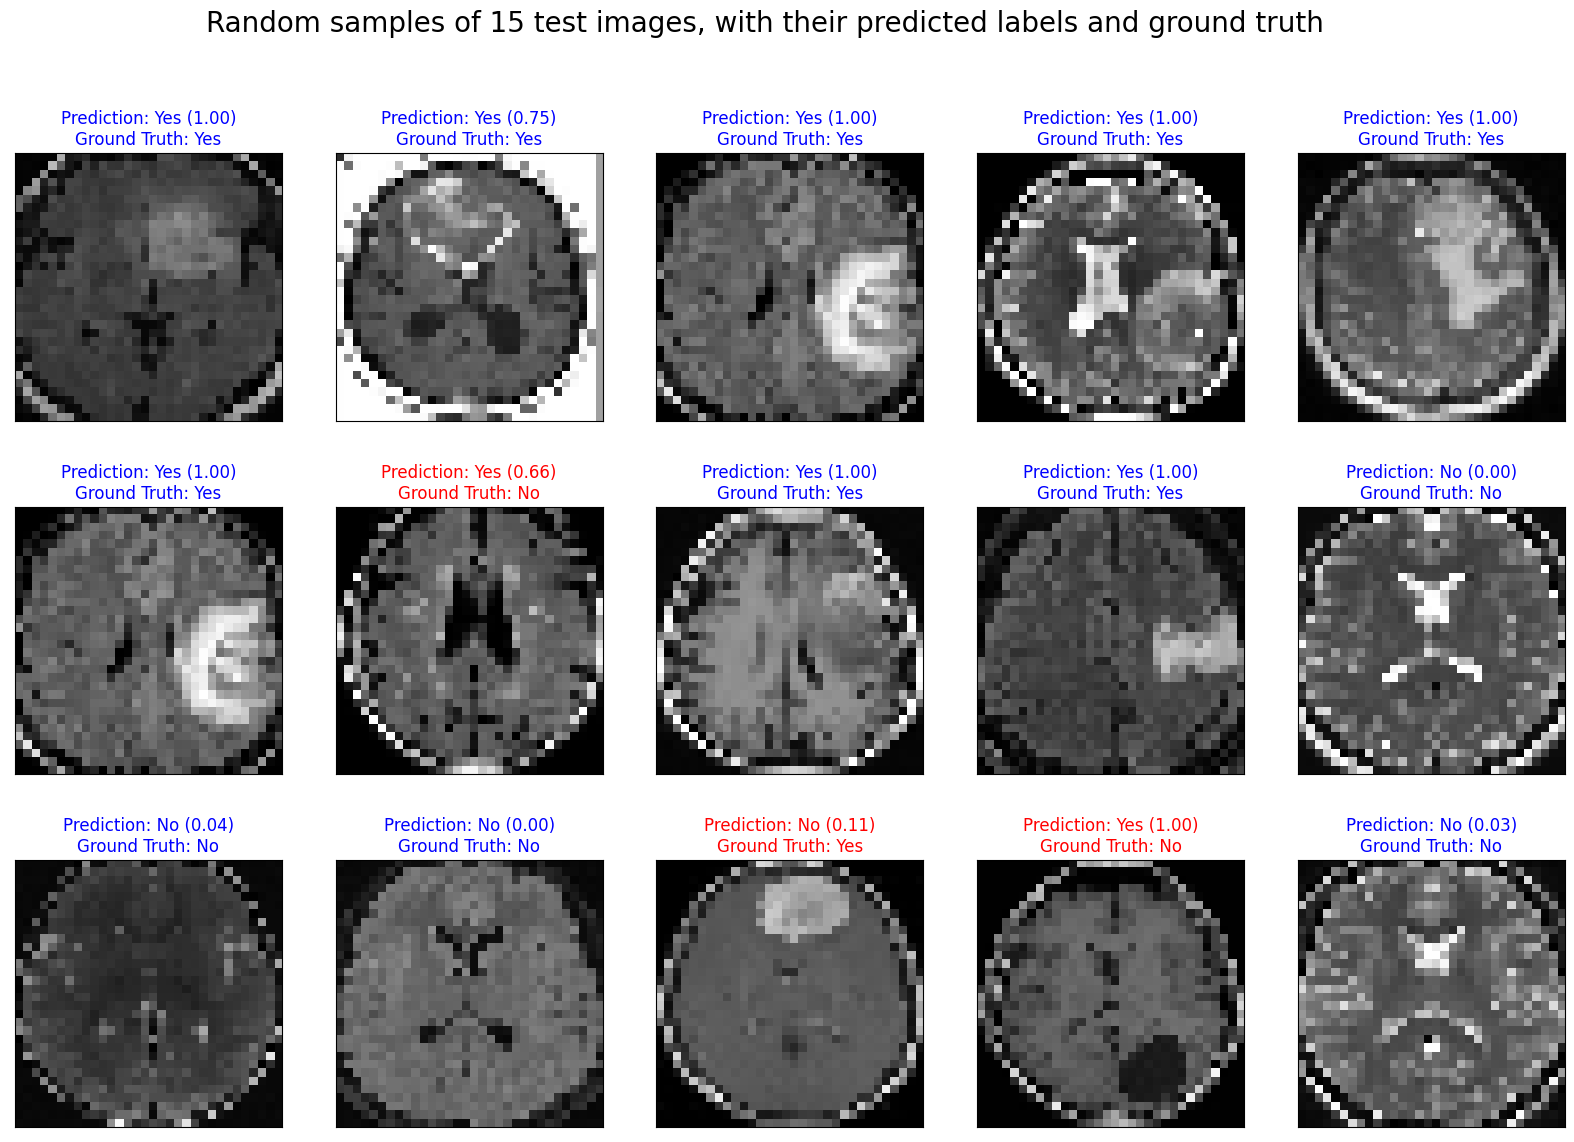

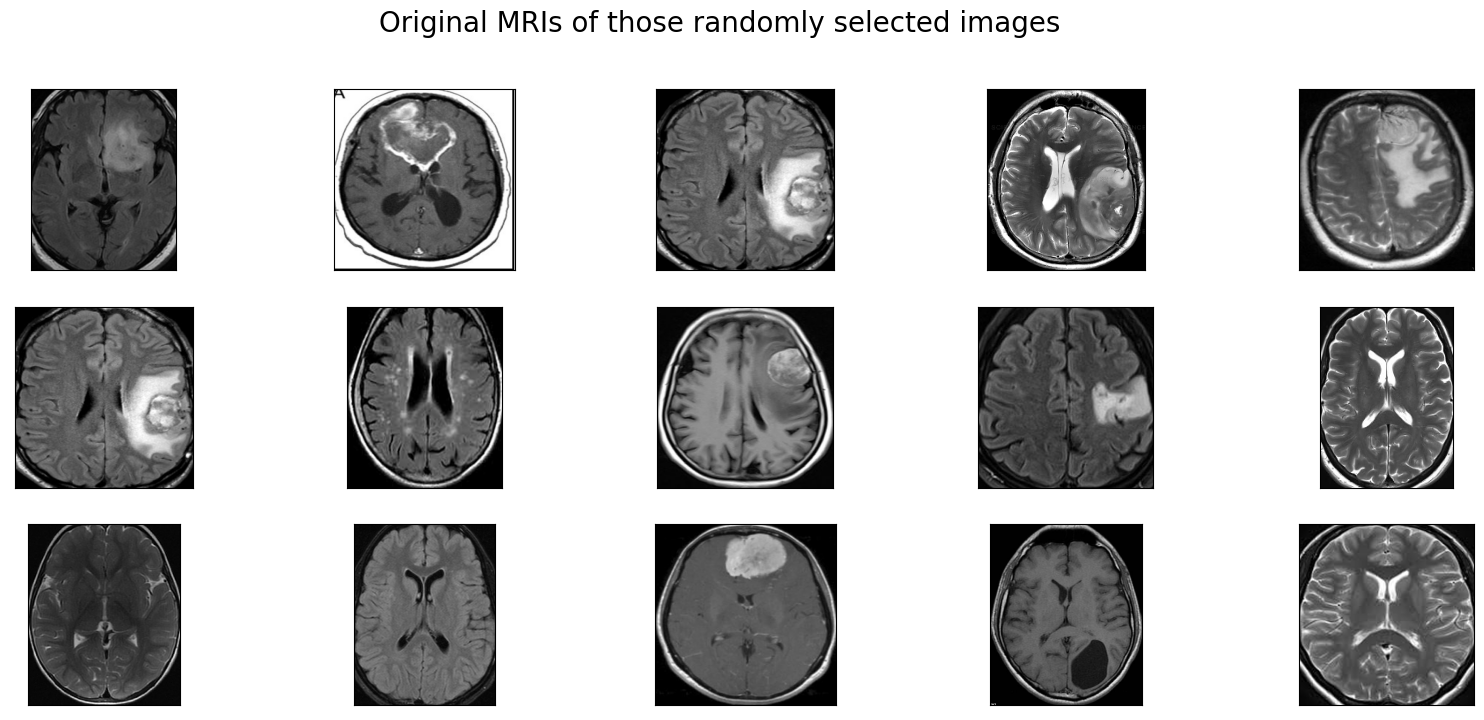

In [22]:
labels = ["No", "Yes"]
y_hat = model.predict(x_valid)
no_of_indices = 15
random_indices = np.random.choice(
    x_valid.shape[0], size=no_of_indices, replace=False)
# Plot a random sample of 15 test images, with their predicted labels and ground truth
figure = plt.figure(figsize=(20, 13))
sub_title = "Random samples of 15 test images, with their predicted labels and ground truth"
figure.suptitle(sub_title, fontsize=20)
for i in range(no_of_indices):
    rand_index = random_indices[i]

    # Display each image
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_valid[rand_index]))

    # Set the title for each image
    prediction_val = y_hat[rand_index][0]
    predict_index = 0 if (prediction_val < 0.5) else 1
    true_index = y_valid[rand_index]
    prediction = labels[predict_index]
    truth = labels[true_index]
    title_color = "blue" if predict_index == true_index else "red"
    ax_title = "Prediction: {} ({:.2f})\nGround Truth: {}".format(
        prediction, prediction_val, truth)
    ax.set_title(ax_title, color=title_color)
plt.show()

# Show the Original MRIs of the randomly selected images
figure = plt.figure(figsize=(20, 8))
figure.suptitle("Original MRIs of those randomly selected images", fontsize=20)
for i in range(no_of_indices):
    # get the original image
    img = x_orig_valid[random_indices[i]]
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img))
plt.show()
